In [1]:
import tensorflow as tf
import numpy as np
from tfUtils import *
import matplotlib.pyplot as plt
import innvestigate

Using TensorFlow backend.


In [2]:
def generate_data(m, n_x, seed = 9):
    np.random.seed = seed
    X = np.random.randn(m, n_x)
    Y = np.zeros((m, 2))
    dist = np.random.randint(low = 0, high = n_x-1, size = m)
    for i in range(m):
        t = np.random.rand();
        if t < 0.5:
            X[i, dist[i]] = -20
            Y[i, 0] = 1
        elif t >= 0.5:
            X[i, dist[i]] = 20
            Y[i, 1] = 1
    return X, Y, dist

In [3]:
X_train, Y_train, dist = generate_data(40000, 100)

In [4]:
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, [None, n_x])
    Y = tf.placeholder(tf.float32, [None, n_y])
    return X, Y

In [5]:
def initialize_parameters(n_x, layers):
    parameters = {}
    layers.insert(0, n_x)
    for i in range(1, len(layers)):
        parameters["W" + str(i)] = tf.get_variable("W" + str(i), [layers[i-1], layers[i]],
                                                  initializer = tf.contrib.layers.xavier_initializer())
        parameters["b" + str(i)] = tf.get_variable("b" + str(i), [1, layers[i]], 
                                                  initializer = tf.zeros_initializer())
    return parameters

In [6]:
def forward_propagation(A, W, b, activation):
    Z = tf.matmul(A, W) + b
    print(Z)
    if activation == "relu":
        A = tf.nn.relu(Z)
    elif activation == "sigmoid":
        A = tf.nn.sigmoid(Z)
    elif activation == "tanh":
        A = tf.nn.tanh(Z)
    elif activation == "linear":
        A = Z
    return A

In [7]:
def compute_cost(Z, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = Z, labels = Y))
    return cost

In [12]:
def model(X_train, Y_train, layers, activations, epochs, batch_size, starting_rate, decay, lambd):
    tf.reset_default_graph()
    m, n_x = X_train.shape
    __, n_y = Y_train.shape
    X, Y = create_placeholders(n_x, n_y)
    l = len(layers)
    parameter_list = []
    parameters = initialize_parameters(n_x, layers)
    A = X
    for i in range(1, len(layers)):
        A = forward_propagation(A, parameters["W" + str(i)], parameters["b" + str(i)], activations[i - 1])
    cost = compute_cost(A, Y)
    hard_A = tf.argmax(tf.nn.softmax(A, dim = 1), axis = 1)
    acc = tf.reduce_mean(tf.cast(tf.equal(hard_A,tf.argmax(Y, axis = 1)), tf.float32))
    for i in range(1, len(layers)):
        cost += lambd * tf.nn.l2_loss(parameters["W" + str(i)])
    global_steps = tf.Variable(0, trainable = False)
    learning_rate = tf.train.exponential_decay(starting_rate, global_steps, 5000, decay, staircase = True)
    train = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost, global_step = global_steps)
    init = tf.global_variables_initializer()
    cost_list = []
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(epochs):
            minibatches = random_minibatches(X_train, Y_train, batch_size, seed = epoch)
            epoch_cost = 0
            for minibatch in minibatches:
                sess.run(train, feed_dict = {X : minibatch[0], Y : minibatch[1]})
                epoch_cost += sess.run(cost, feed_dict = {X : minibatch[0], Y : minibatch[1]}) / len(minibatches)
            cost_list.append(epoch_cost)        
            if epoch % 5 == 0:
                print(epoch_cost)
        parameter_names = ["W1", "b1", "W2", "b2", "W3", "b3", "W4", "b4"]
        for j in range(len(parameter_names)):
            parameter_list.append(sess.run(parameters[parameter_names[j]]))
        print("accuracy", sess.run(acc, feed_dict = {X : X_train, Y : Y_train}))
    sess.close()
    plt.plot(np.array(cost_list), '-b')
    return parameter_list

In [13]:
tf.reset_default_graph()

In [34]:
layers = [200, 300, 100, 2]
activations = ["relu", "relu", "tanh", "linear"]
epochs = 30
batch_size = 32
starting_rate = 0.0003
decay = .9
lambd = 0

In [15]:
parameter_list = model(X_train, Y_train, layers , activations, epochs, batch_size, starting_rate, decay, lambd)

Tensor("add:0", shape=(?, 200), dtype=float32)
Tensor("add_1:0", shape=(?, 300), dtype=float32)
Tensor("add_2:0", shape=(?, 100), dtype=float32)
Tensor("add_3:0", shape=(?, 2), dtype=float32)
0.05508509385189966
1.663475734121675e-05
5.417549628724317e-07
1.9377465103609416e-08
2.712011175631804e-10
0.0
accuracy 1.0


In [18]:
from keras.layers import Input, Activation, Dense, Flatten
from keras.models import Model

In [19]:
X_train_ = X_train.reshape(-1, 10, 10, 1)
Y_train_ = Y_train.reshape(-1, 2)

In [20]:
def create_model(input_shape, layers, activations, use_soft):
    X_input = Input(input_shape)
    X = Flatten()(X_input)
    X = Dense(layers[0], activation = activations[0])(X)
    X = Dense(layers[1], activation = activations[1])(X)
    X = Dense(layers[2], activation = activations[2])(X)
    if use_soft :
        X = Dense(layers[3], activation = 'softmax')(X)
    else :
        X = Dense(layers[3], activation = 'linear')(X)
    model = Model(inputs = X_input, outputs = X)
    return model    

In [21]:
layers = [200, 300, 100, 2]
activations = ["relu", "relu", "tanh", "linear"]

In [22]:
model = create_model((10, 10, 1), layers, activations, False)
modelp = create_model((10, 10, 1), layers, activations, True)

In [23]:
for j in range(len(parameter_list)):
    if j % 2 == 0:
        parameter_list[j] = parameter_list[j]
    else:
        parameter_list[j] = parameter_list[j].reshape(-1)

In [24]:
model.set_weights(parameter_list)
modelp.set_weights(parameter_list)
modelp.compile(optimizer='adagrad', loss='categorical_crossentropy', metrics=['accuracy'])
#modelp.fit(x = X_train_, y = Y_train_, epochs = 30, batch_size = 50)
modelp.evaluate(x = X_train_, y = Y_train_)

40000/40000 [==============================] - 2s 41us/step


[1.1920928955078125e-07, 1.0]

In [27]:
model.set_weights(parameter_list)
analyzer = innvestigate.create_analyzer("lrp.alpha_2_beta_1", model)

In [ ]:
len(parameter_list)

In [28]:
analysis = analyzer.analyze(X_train_[0:100,:])

In [ ]:
dist

In [29]:
rel_me = np.zeros((len(dist), 100))
for i in range(len(dist)):
    rel_me[i, dist[i]] = 1

In [30]:
rel_me = np.reshape(rel_me, (-1, 10, 10)) 

/home/labic/miniconda3/envs/pavan/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


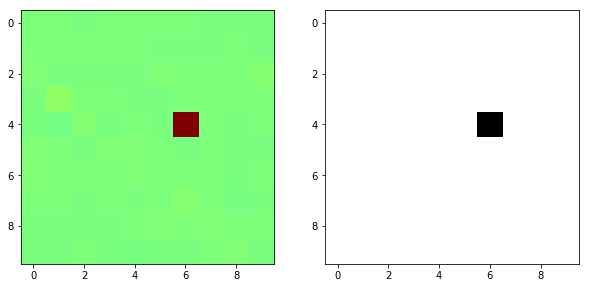

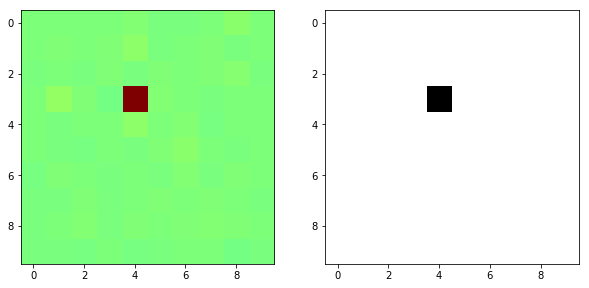

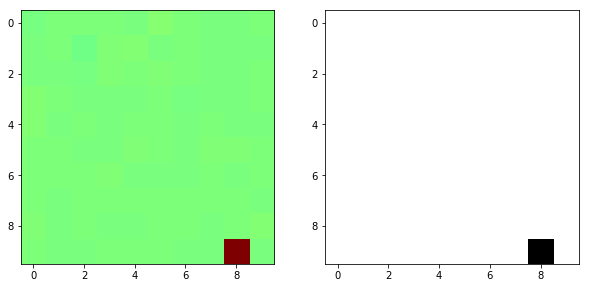

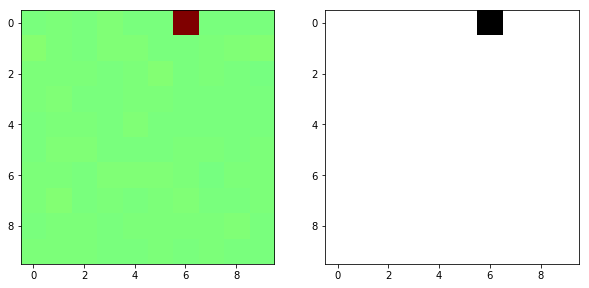

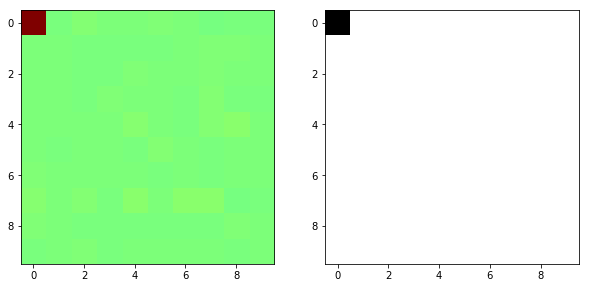

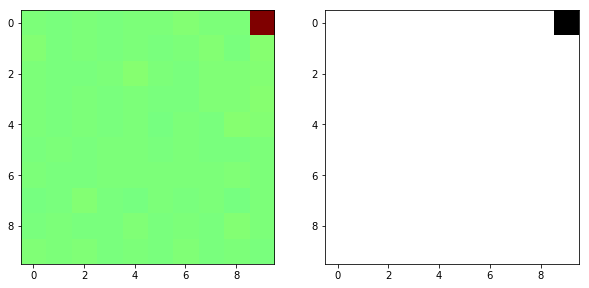

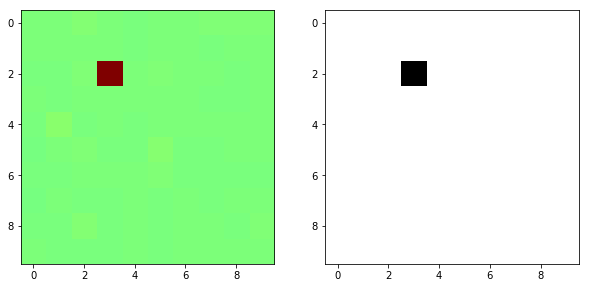

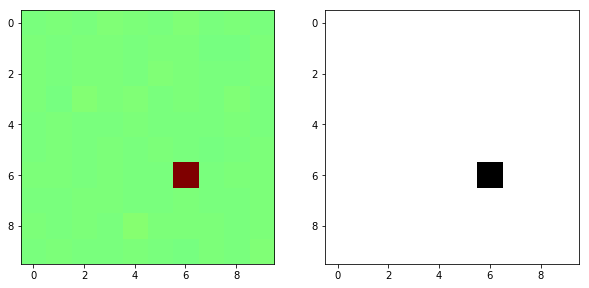

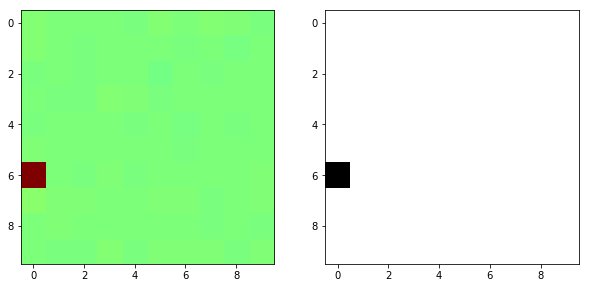

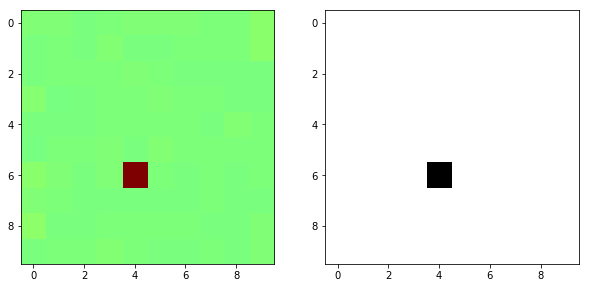

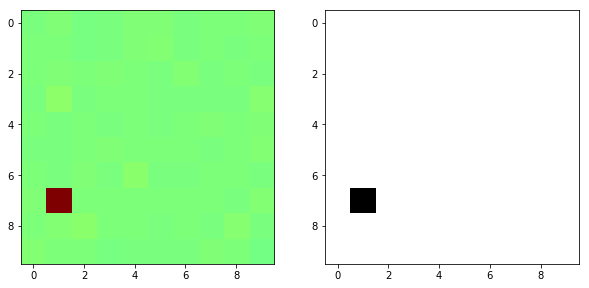

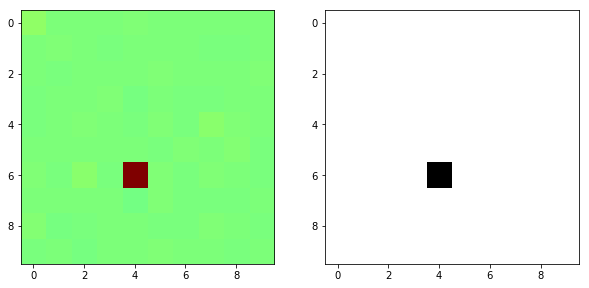

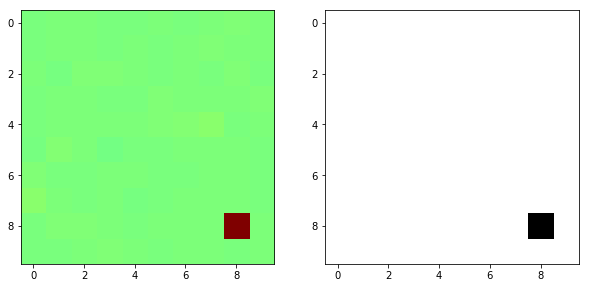

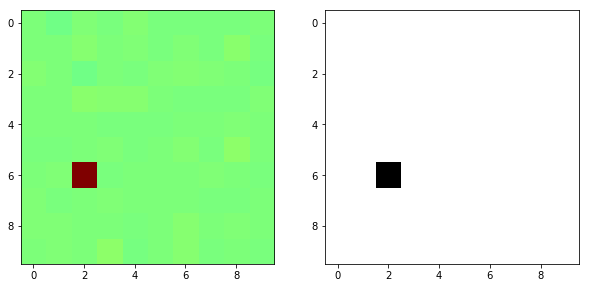

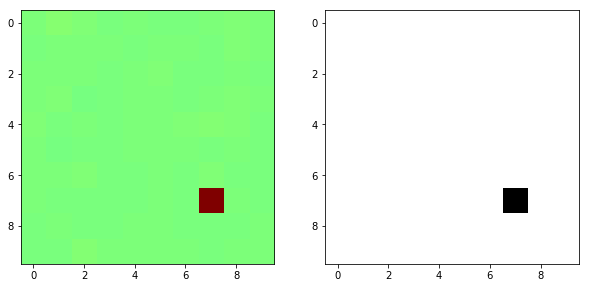

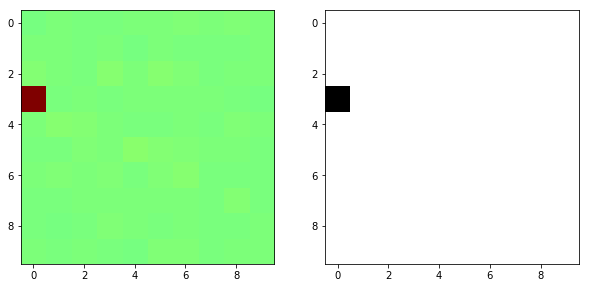

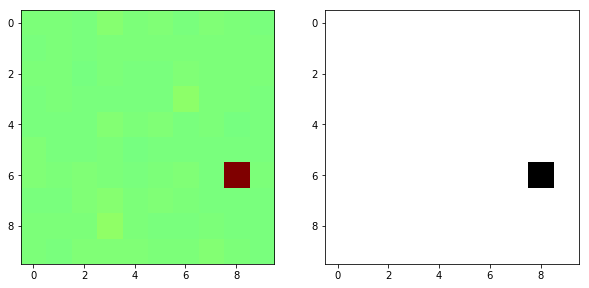

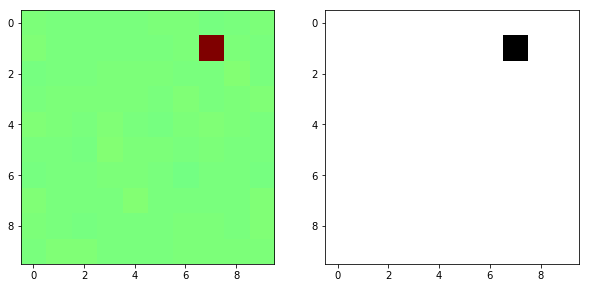

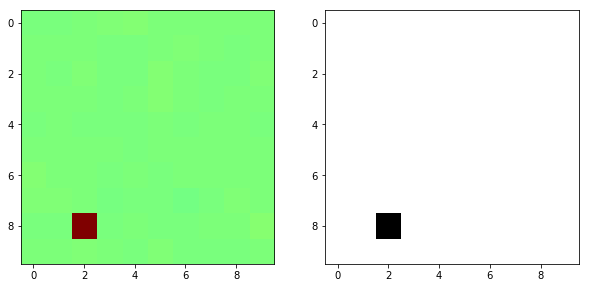

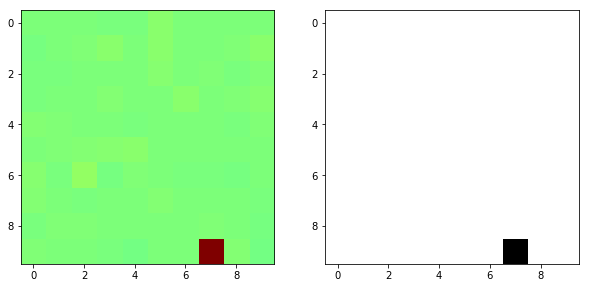

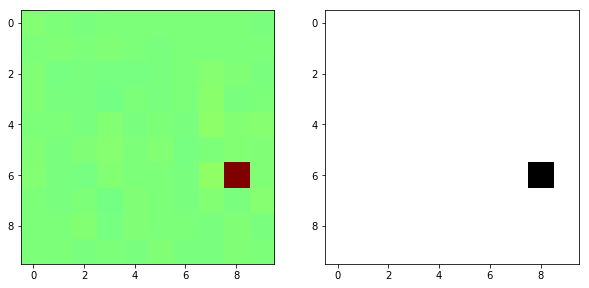

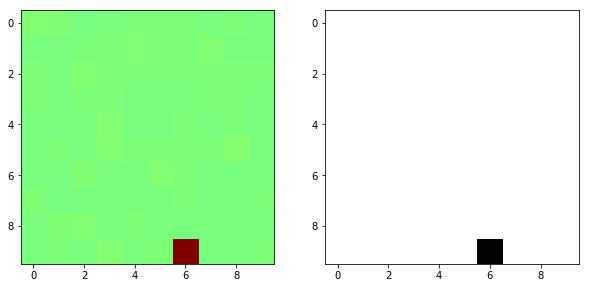

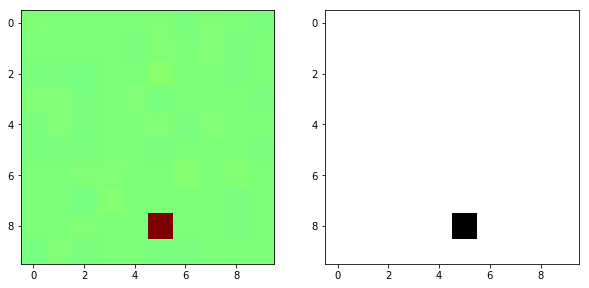

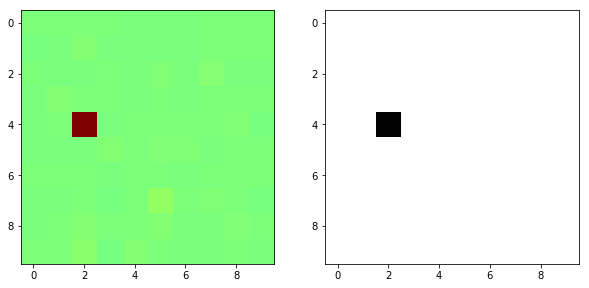

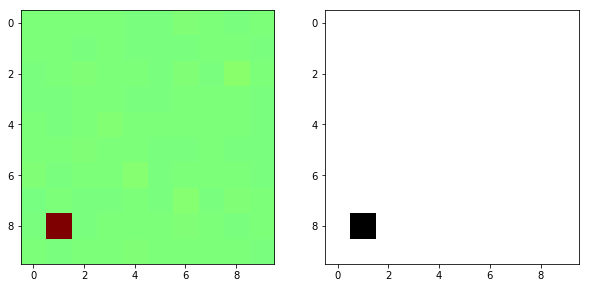

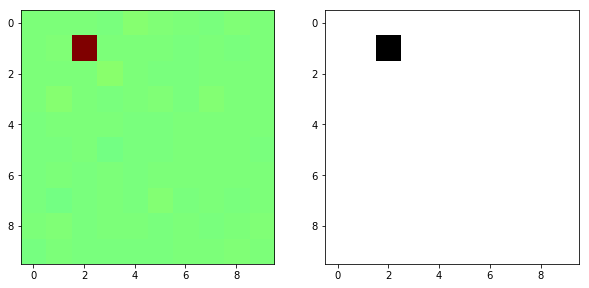

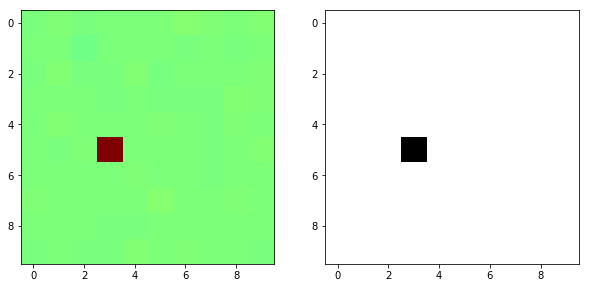

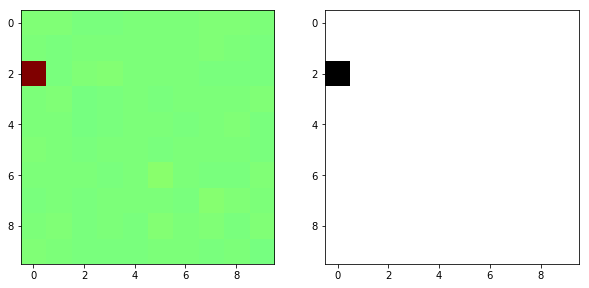

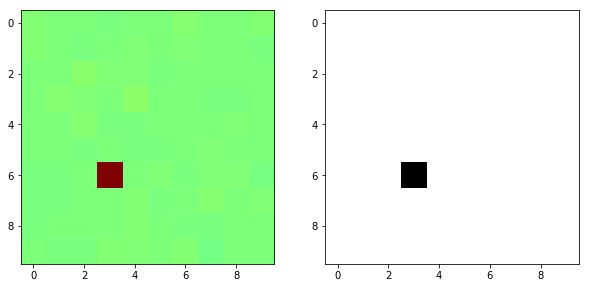

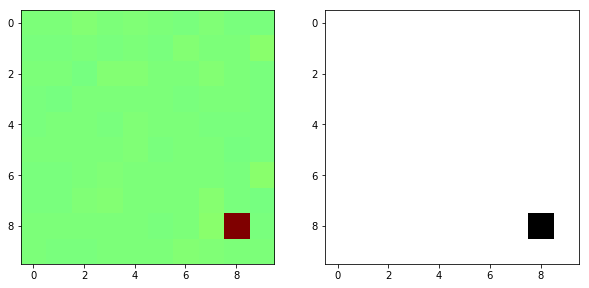

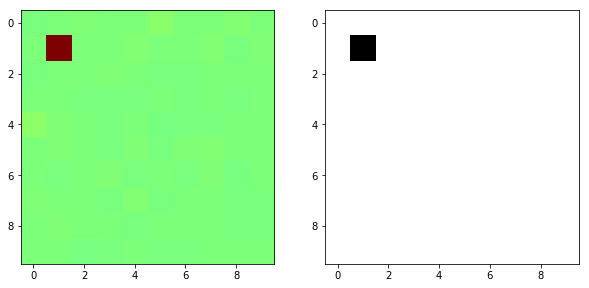

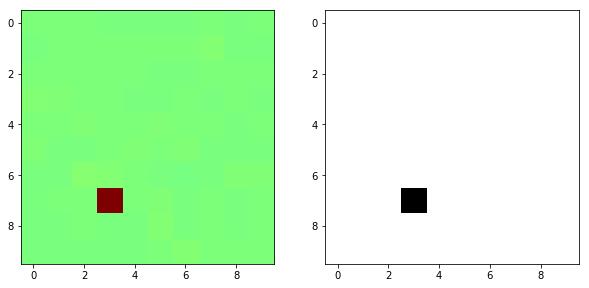

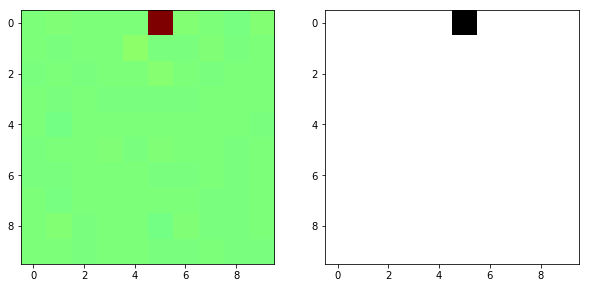

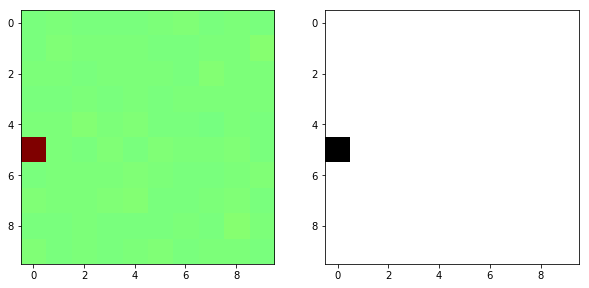

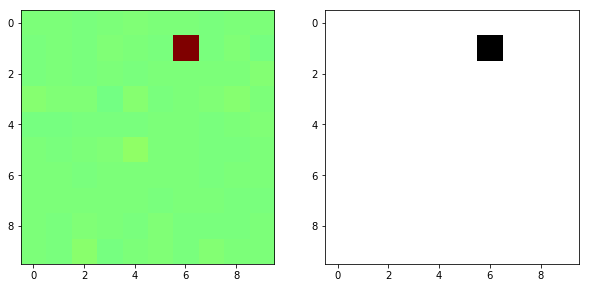

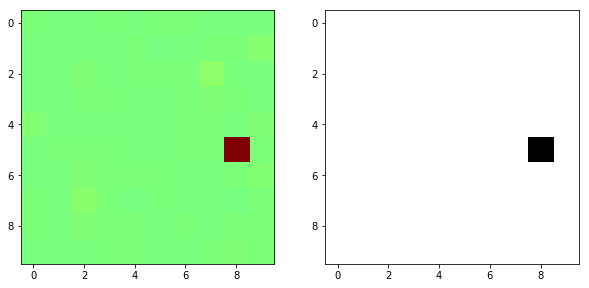

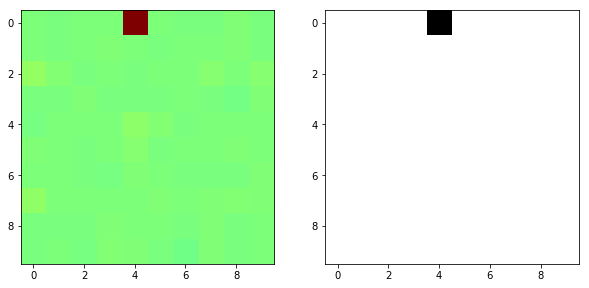

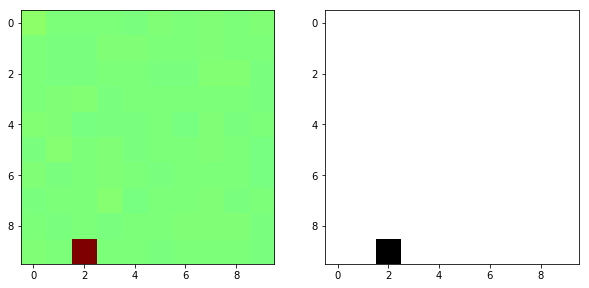

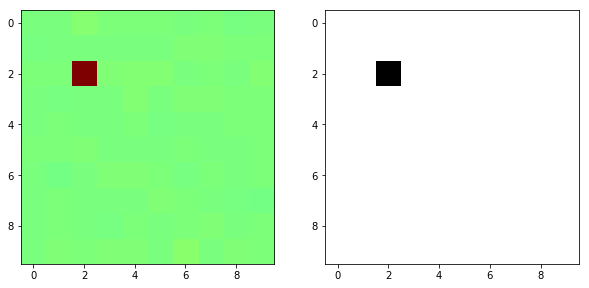

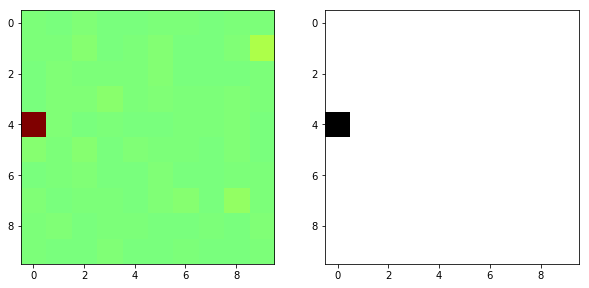

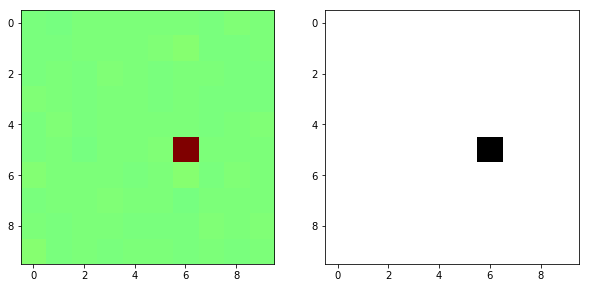

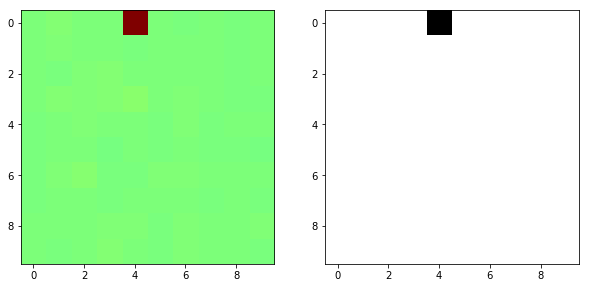

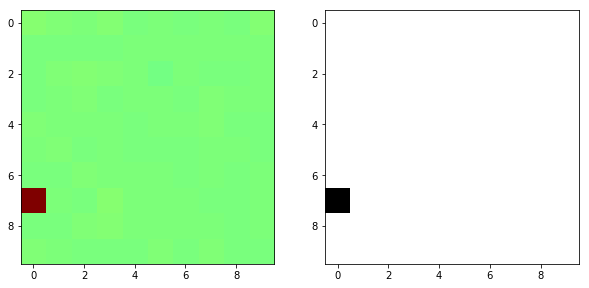

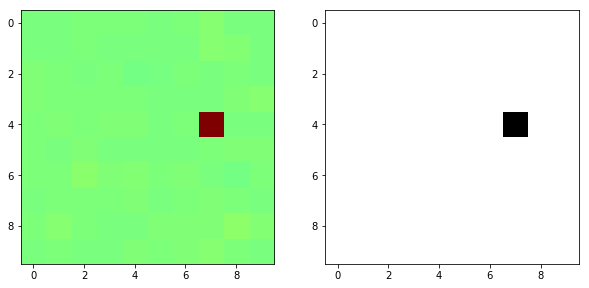

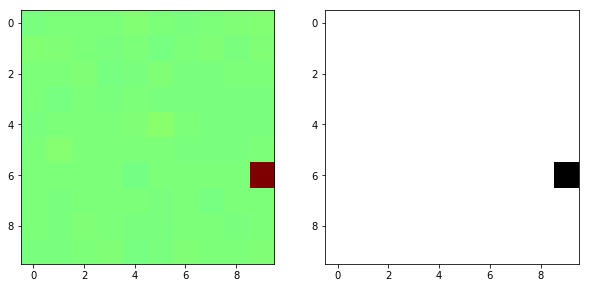

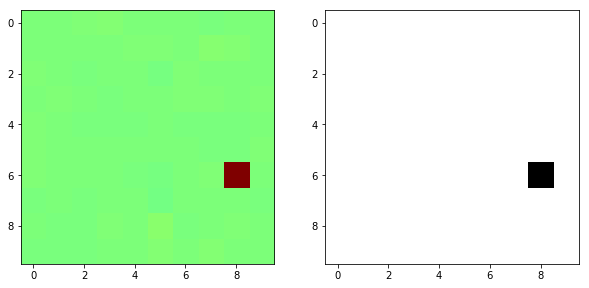

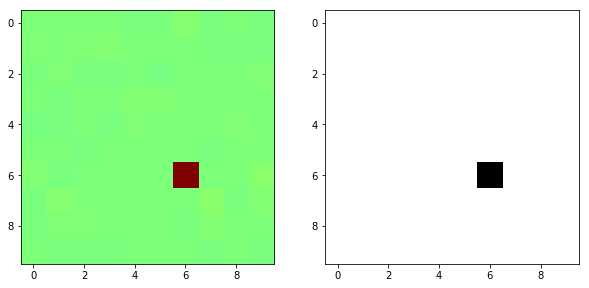

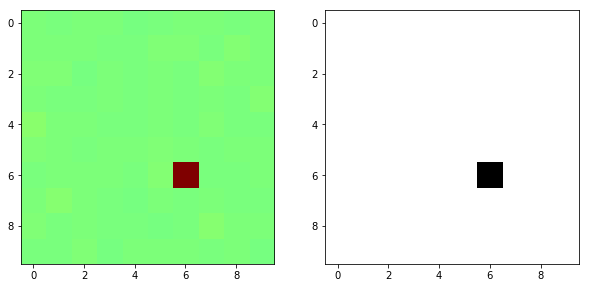

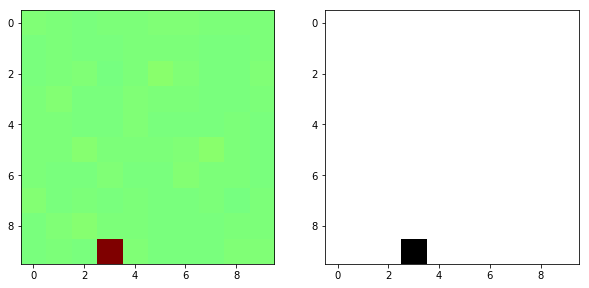

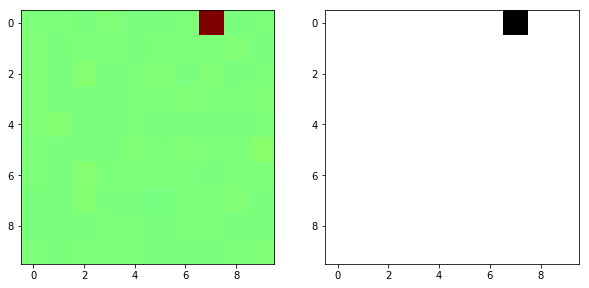

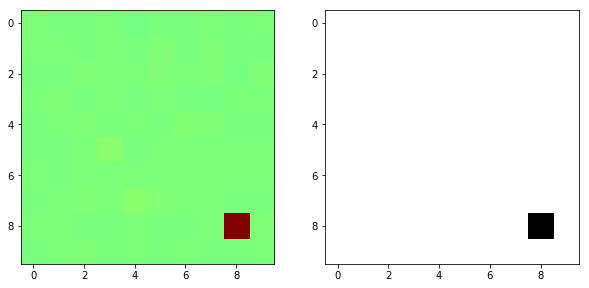

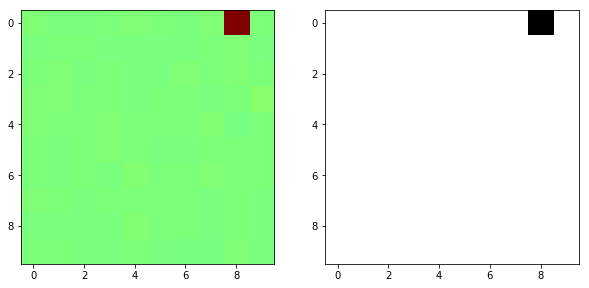

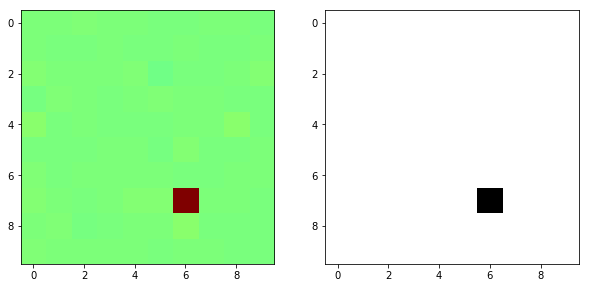

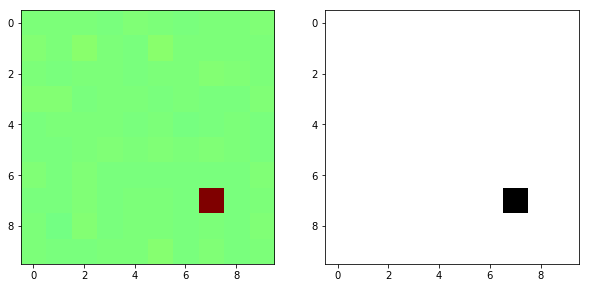

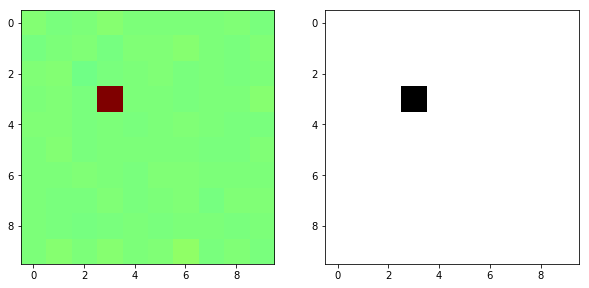

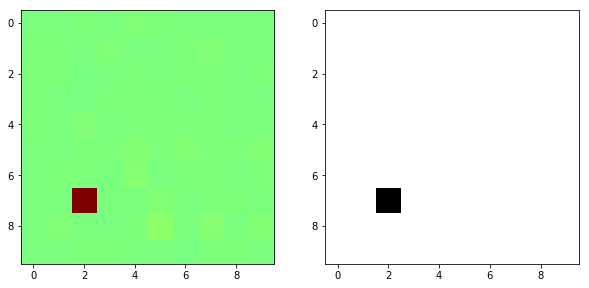

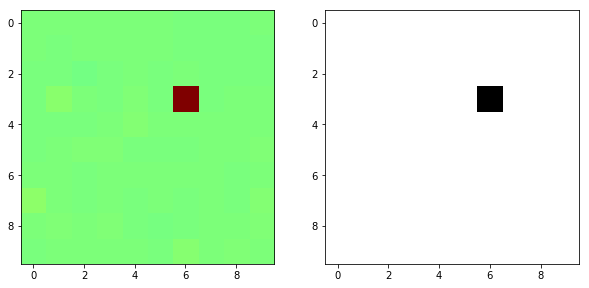

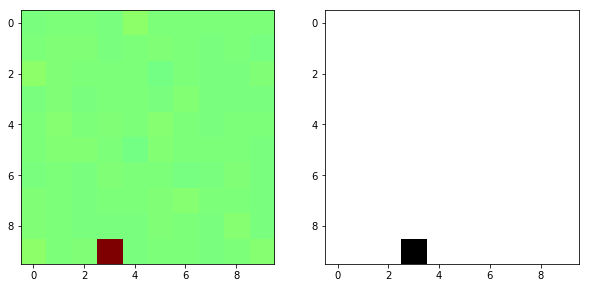

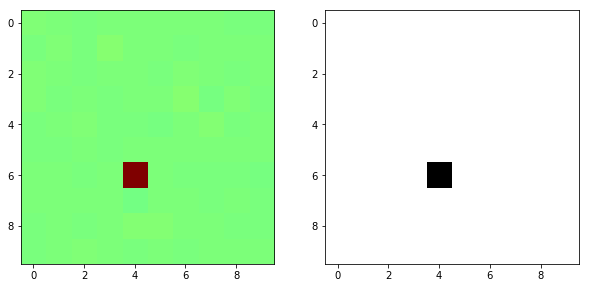

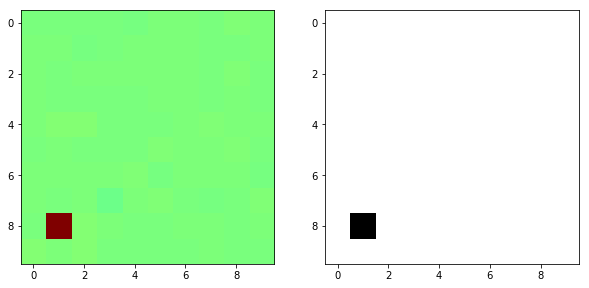

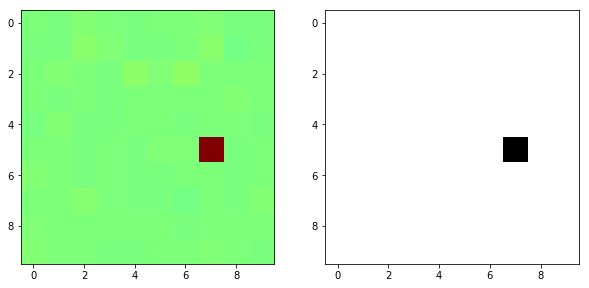

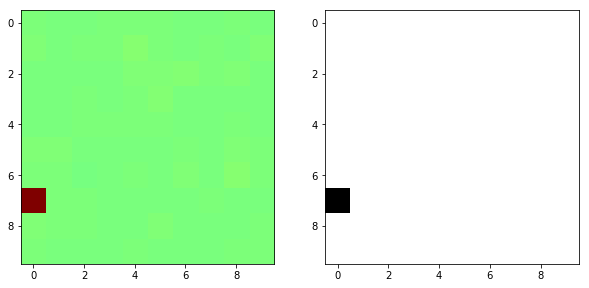

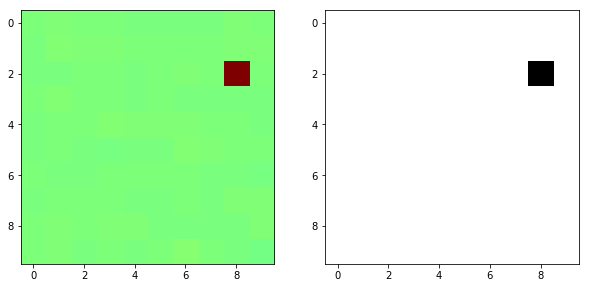

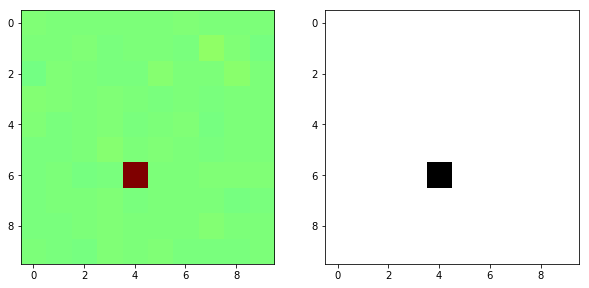

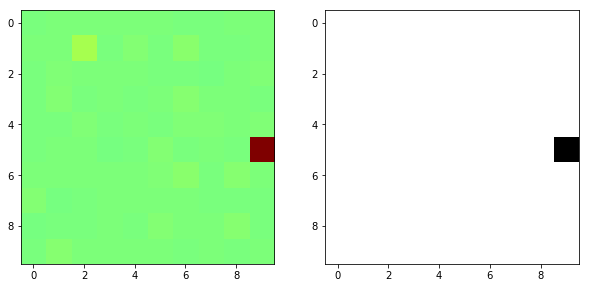

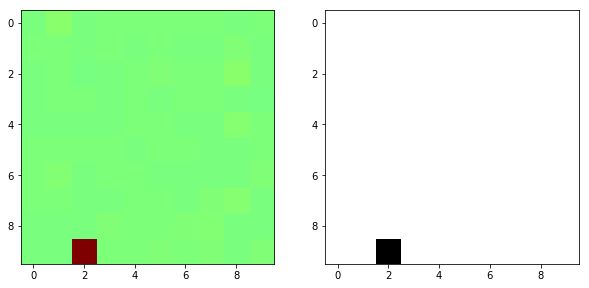

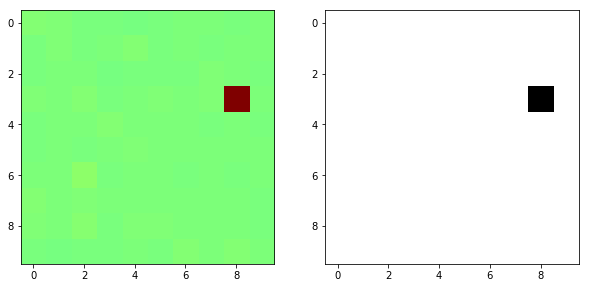

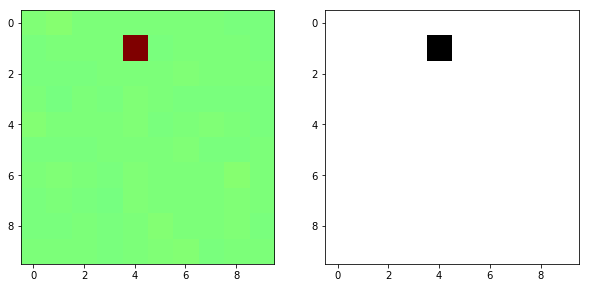

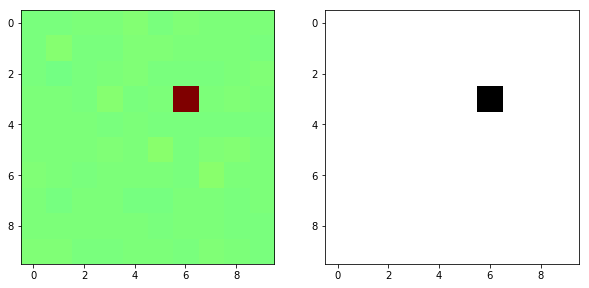

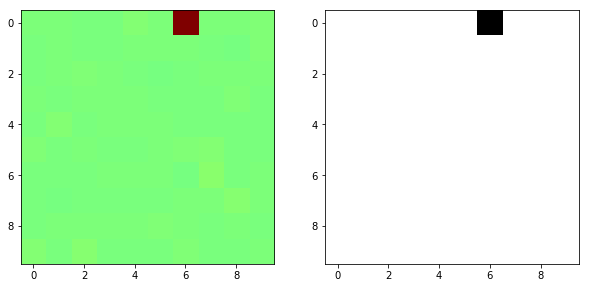

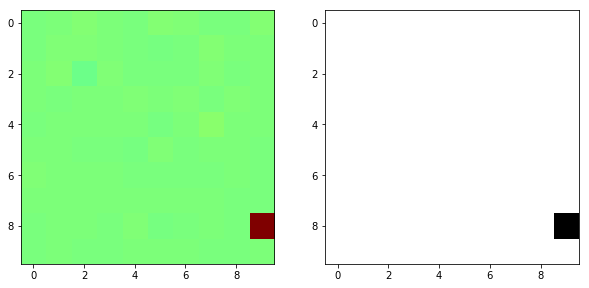

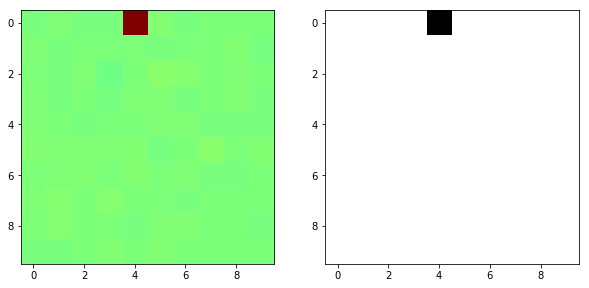

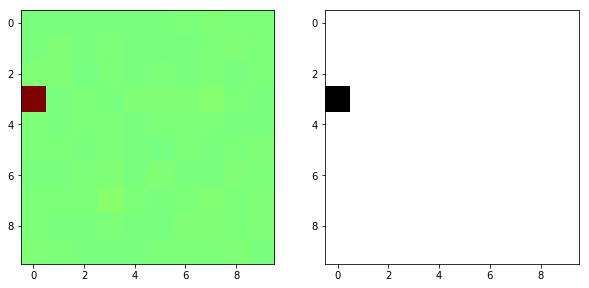

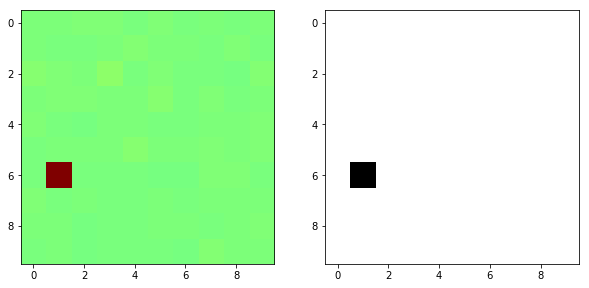

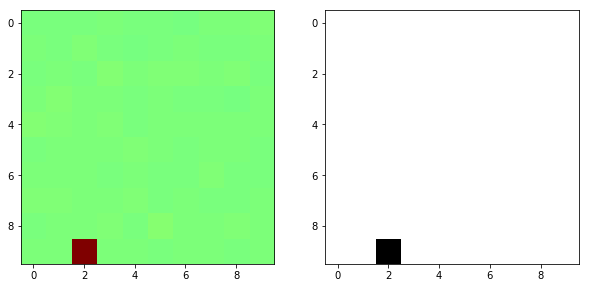

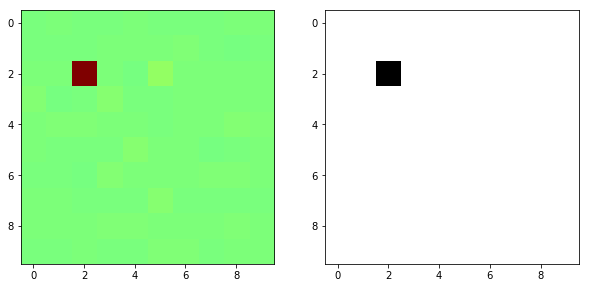

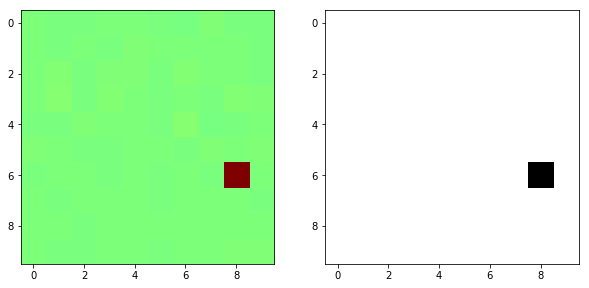

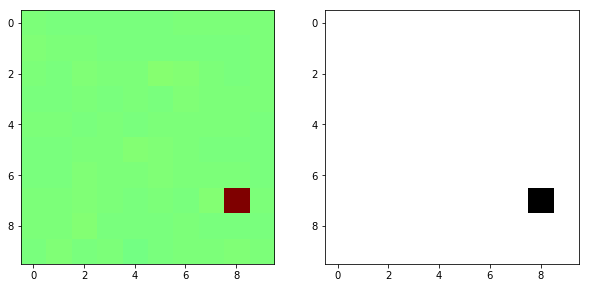

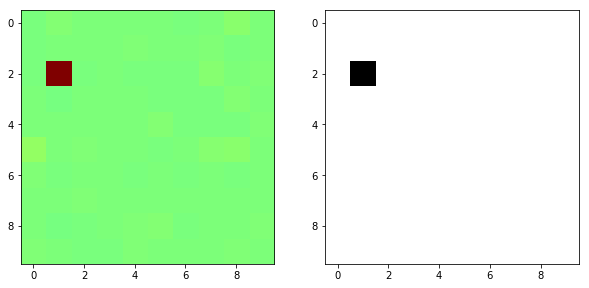

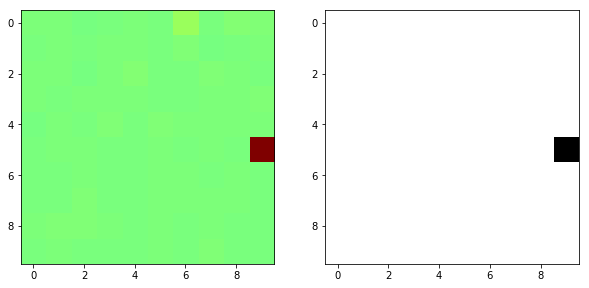

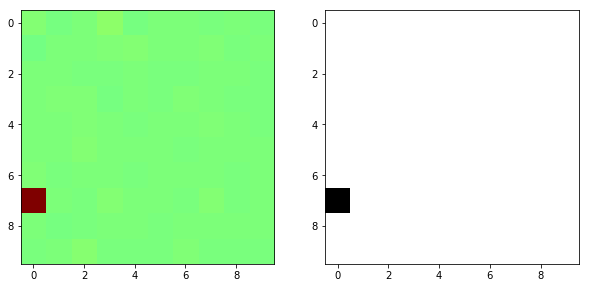

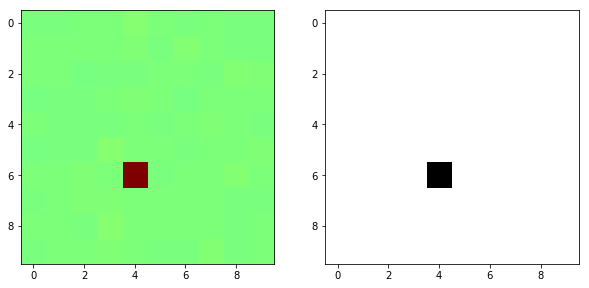

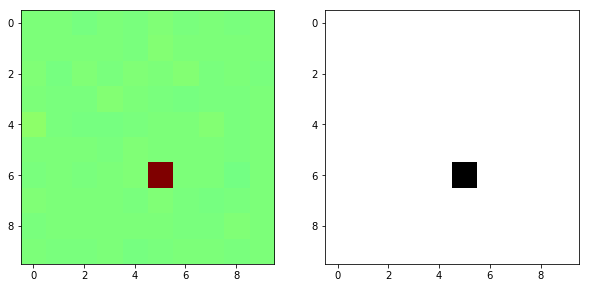

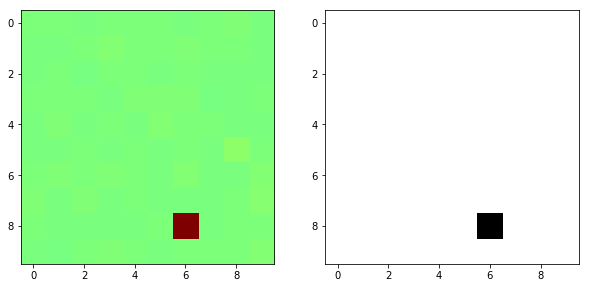

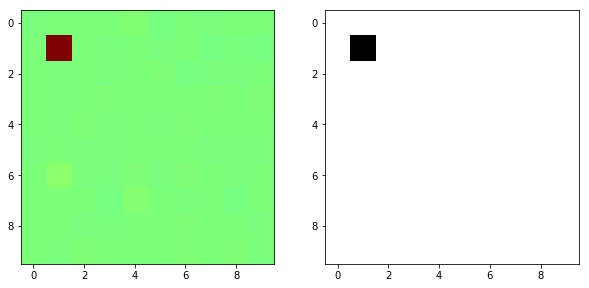

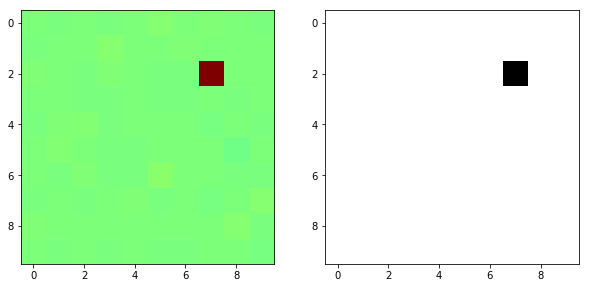

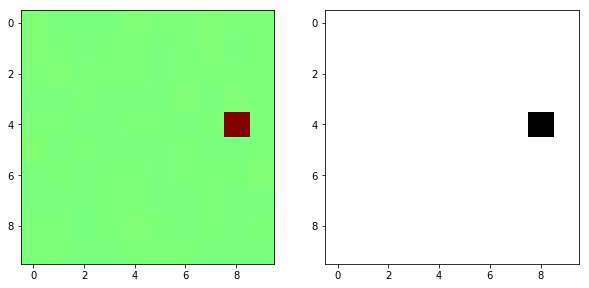

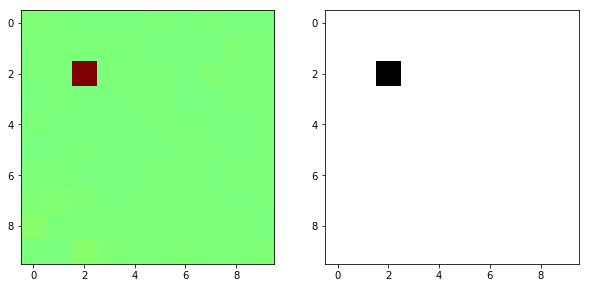

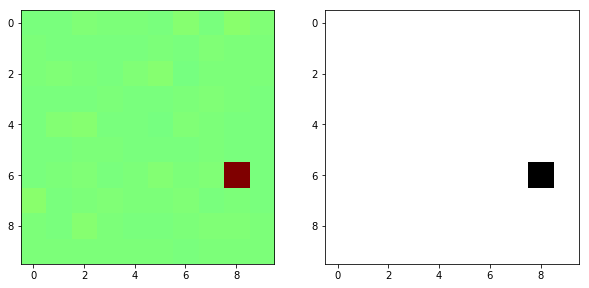

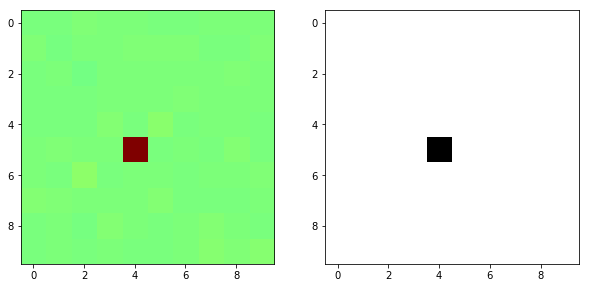

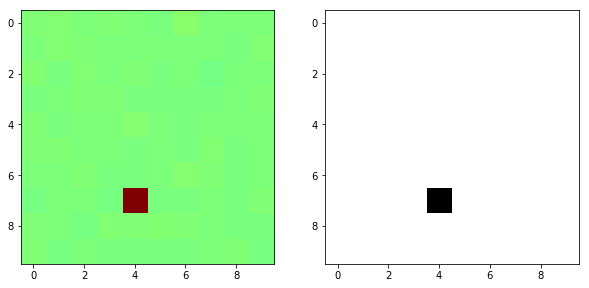

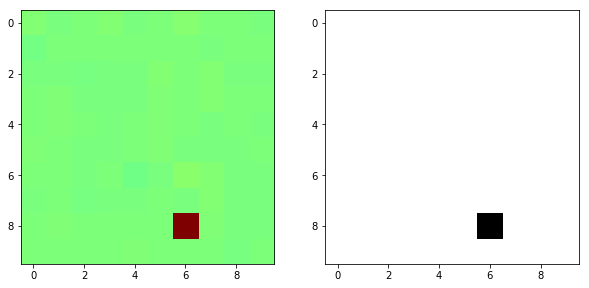

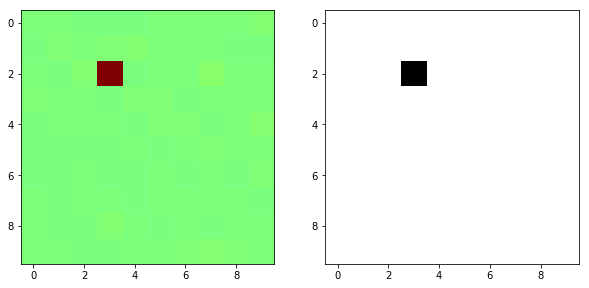

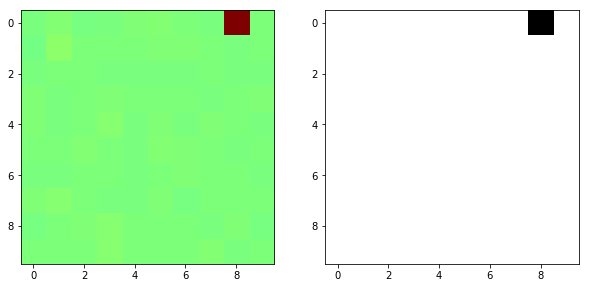

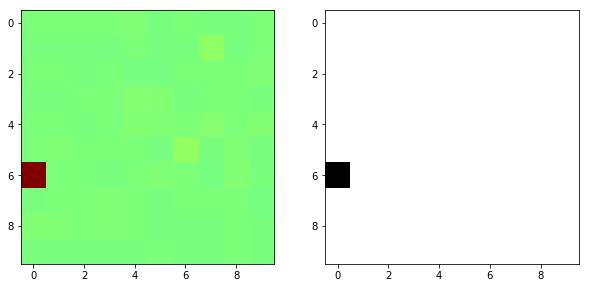

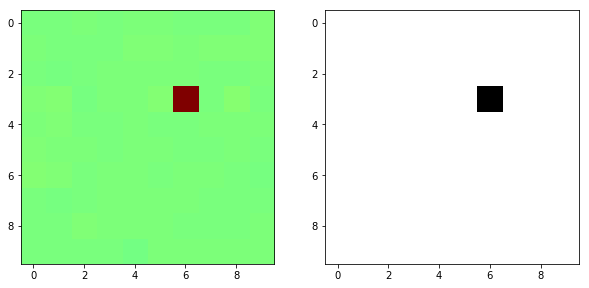

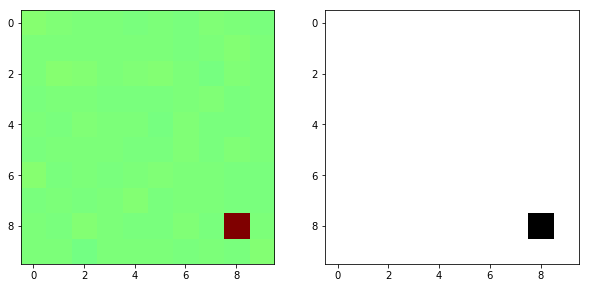

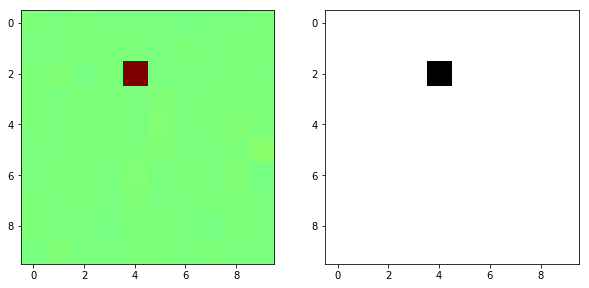

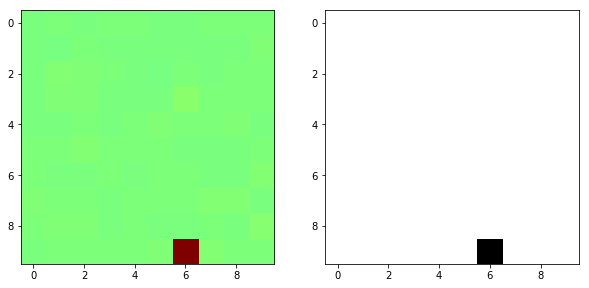

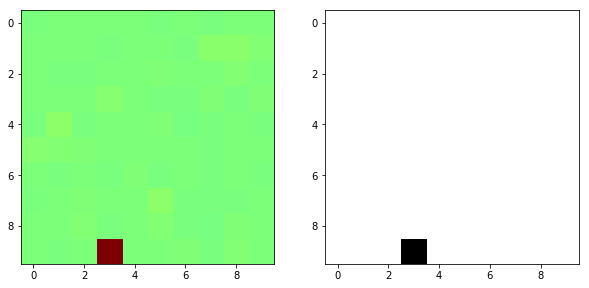

In [31]:
plt.close()
for i in range(100):
    f, axarr = plt.subplots(1, 2, figsize=(10, 10))
    m = np.max(np.abs(analysis[i,:,:,0]))
    a = ((analysis[i,:,:,0]/m)+1)/2
    fig = axarr[0].imshow(a, vmax = 1, vmin = 0, cmap = "jet")
    fig = axarr[1].imshow(rel_me[i,:,:], cmap = "binary")
plt.show()

In [ ]:
for j in range(len(parameter_list)):
    if j % 2 == 0:
        parameter_list[j] = parameter_list[j].T
    else:
        parameter_list[j] = parameter_list[j].reshape(-1, 1)

In [ ]:
A1 = forward_propagation(X_train, parameter_list[0], parameter_list[1], 'relu')
A2 = forward_propagation(A1, parameter_list[2], parameter_list[3], 'relu')
A3 = forward_propagation(A2, parameter_list[4], parameter_list[5], 'tanh')
A4 = tf.nn.softmax(forward_propagation(A1, parameter_list[6], parameter_list[7], 'linear'))

In [ ]:
a = np.array([[1, 2, 3, 4, 5, 6], [7, 8, 9, 10, 11, 12]])

In [ ]:
a

In [ ]:
a.reshape(-1, 2, 3)

In [ ]:
a.reshape(-1, 6)

In [ ]:
parameters = initialize_parameters(100, layers)

In [ ]:
parameters["b4"]

In [ ]:
X_train.shape

In [32]:
parameter_list

[array([[ 0.03188675, -0.07985324,  0.01997273, ...,  0.09498457,
         -0.00206399,  0.08622344],
        [-0.02813617,  0.1030919 , -0.04024752, ..., -0.06495274,
         -0.09868842, -0.00212712],
        [-0.06838794, -0.03787819, -0.09842584, ..., -0.02684524,
          0.05173061, -0.13299231],
        ...,
        [-0.07553306, -0.1106802 ,  0.00893857, ..., -0.02642979,
         -0.05003772,  0.06356729],
        [-0.03199162, -0.10809384, -0.02854529, ...,  0.10712507,
         -0.12673314,  0.12715113],
        [ 0.13472992, -0.11246429,  0.07000484, ..., -0.04557675,
         -0.13576996, -0.07521444]], dtype=float32),
 array([ 8.53692088e-03,  2.31901165e-02,  5.25506400e-03,  3.63682769e-02,
         9.61235538e-03,  1.85988080e-02,  3.79115529e-02,  2.72234343e-03,
         2.11929306e-02,  5.71306795e-03,  2.95886081e-02, -7.57525302e-03,
         3.75211537e-02,  8.48767906e-03,  2.18879115e-02,  1.26442481e-02,
         1.64036988e-03,  3.31021026e-02,  1.24476720e